# Stock Prices prediction using LSTM

In [1]:
import pandas as pd
import numpy as np

# To remove the scientific notation from numpy arrays
np.set_printoptions(suppress=True)

In [2]:
# install the nsepy library to get stock prices
# !pip install nsepy

In [3]:
# Getting Stock data using nsepy library
from nsepy import get_history
from datetime import datetime

startDate=datetime(2019, 1,1)
endDate=datetime(2020, 8, 4)

# Fetching the data
StockData=get_history(symbol='INFY', start=startDate, end=endDate)
print(StockData.shape)
StockData.head()

(393, 14)


,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,
2019-01-01,INFY,EQ,658.95,660.95,666.3,654.15,665.95,665.05,660.66,2943390,1.944579e+14,45422,1282161,0.4356
2019-01-02,INFY,EQ,665.05,666.00,674.0,662.05,668.00,669.05,669.97,7416655,4.968963e+14,108094,3880800,0.5233
2019-01-03,INFY,EQ,669.05,672.00,677.0,663.10,668.00,669.15,669.66,6827249,4.571929e+14,125781,3676359,0.5385
2019-01-04,INFY,EQ,669.15,671.75,673.9,651.00,660.25,661.05,660.17,7889310,5.208305e+14,187590,3747741,0.4750
2019-01-07,INFY,EQ,661.05,665.00,673.6,661.50,671.70,671.70,667.51,8046340,5.370974e+14,132736,4711672,0.5856


In [4]:
# Creating a column as date
StockData['TradeDate']=StockData.index
StockData.tail()

,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble,TradeDate
Date,,,,,,,,,,,,,,,
2020-07-29,INFY,EQ,962.85,953.25,960.00,943.60,951.95,954.15,952.22,11152710,1.061982e+15,212215,4338542,0.3890,2020-07-29
2020-07-30,INFY,EQ,954.15,962.00,972.65,958.75,962.15,961.45,965.59,12492569,1.206274e+15,222807,5962965,0.4773,2020-07-30
2020-07-31,INFY,EQ,961.45,969.25,986.45,953.30,967.75,966.00,971.12,12704359,1.233742e+15,195979,3201880,0.2520,2020-07-31
2020-08-03,INFY,EQ,966.00,960.00,965.40,947.45,955.30,956.90,954.94,8480166,8.098077e+14,164566,4108547,0.4845,2020-08-03
2020-08-04,INFY,EQ,956.90,960.45,970.70,940.55,952.00,949.85,949.99,11133259,1.057652e+15,166839,5087564,0.4570,2020-08-04


### Plotting the closing  prices of stock

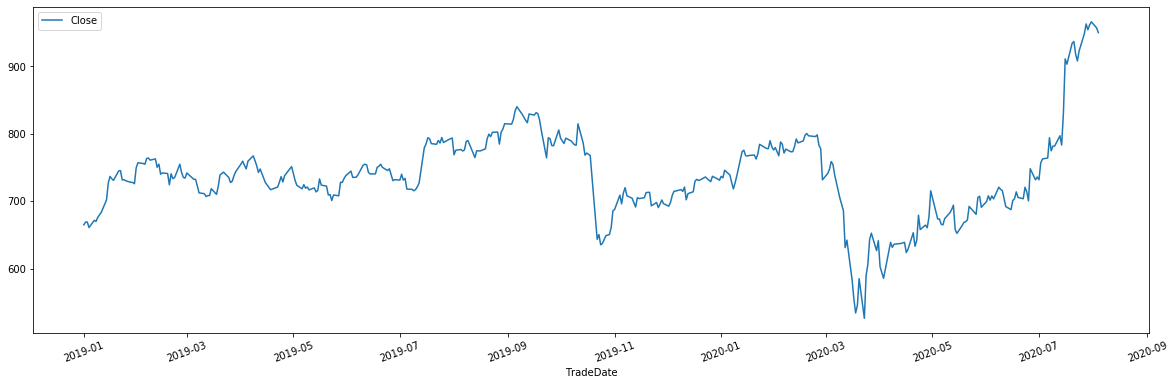

In [5]:
%matplotlib inline
StockData.plot(x='TradeDate', y='Close', kind='line', figsize=(20,6), rot=20)

### Preparing the data

In [6]:
FullData=StockData[['Close']].values
FullData[0:5]

array([[665.05],
       [669.05],
       [669.15],
       [661.05],
       [671.7 ]])

### Feature Scaling for fast training

In [7]:
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()

DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData

X[0:5]

array([[0.31532249],
       [0.32442271],
       [0.32465021],
       [0.30622227],
       [0.3304516 ]])

In [8]:
# split into samples
X_samples = list()
y_samples = list()

NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices

# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)

In [9]:
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
X_data.shape

(383, 10, 1)

In [10]:
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
y_data.shape

(383, 1)

In [11]:
# Choosing the number of testing data records
TestingRecords=10

# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]

In [12]:
# Printing the shape of training and testing
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(373, 10, 1)
(373, 1)
(10, 10, 1)
(10, 1)


In [13]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:5], y_train[0:5]):
    print(inp,'-->', out)

[[0.31532249]
 [0.32442271]
 [0.32465021]
 [0.30622227]
 [0.3304516 ]
 [0.32669776]
 [0.34046184]
 [0.34865203]
 [0.35729724]
 [0.39915823]] --> [0.45535206]
[[0.32442271]
 [0.32465021]
 [0.30622227]
 [0.3304516 ]
 [0.32669776]
 [0.34046184]
 [0.34865203]
 [0.35729724]
 [0.39915823]
 [0.45535206]] --> [0.47855762]
[[0.32465021]
 [0.30622227]
 [0.3304516 ]
 [0.32669776]
 [0.34046184]
 [0.34865203]
 [0.35729724]
 [0.39915823]
 [0.45535206]
 [0.47855762]] --> [0.47070868]
[[0.30622227]
 [0.3304516 ]
 [0.32669776]
 [0.34046184]
 [0.34865203]
 [0.35729724]
 [0.39915823]
 [0.45535206]
 [0.47855762]
 [0.47070868]] --> [0.46524855]
[[0.3304516 ]
 [0.32669776]
 [0.34046184]
 [0.34865203]
 [0.35729724]
 [0.39915823]
 [0.45535206]
 [0.47855762]
 [0.47070868]
 [0.46524855]] --> [0.49721306]


In [14]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [15]:
# pip install tensorflow

### Fitting the Deep Learning LSTM model

In [16]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(LSTM(units = 10, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))


# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', input_shape = (TimeSteps, TotalFeatures), return_sequences=True))

# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [17]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 10)            480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 5)             320       
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


In [18]:
import time
# Measuring the time taken by the model to train
StartTime=time.time()

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')

Epoch 1/100
75/75 [==============================] - 1s 15ms/step - loss: 0.1525
Epoch 2/100
75/75 [==============================] - 1s 17ms/step - loss: 0.0128: 0s - l
Epoch 3/100
75/75 [==============================] - 1s 13ms/step - loss: 0.0074
Epoch 4/100
75/75 [==============================] - 1s 13ms/step - loss: 0.0074
Epoch 5/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0066
Epoch 6/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0065
Epoch 7/100
75/75 [==============================] - 1s 15ms/step - loss: 0.0066
Epoch 8/100
75/75 [==============================] - 1s 15ms/step - loss: 0.0064
Epoch 9/100
75/75 [==============================] - 1s 14ms/step - loss: 0.0064
Epoch 10/100
75/75 [==============================] - 1s 13ms/step - loss: 0.0060
Epoch 11/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0060
Epoch 12/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0060
Epoch 13/100
75/7

In [19]:
import tensorflow as tf

In [20]:
tf.__version__

'2.3.0'

### Generating predictions on testing data

In [21]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

array([[ 977.57587],
       [ 953.275  ],
       [ 943.84375],
       [ 952.00256],
       [ 983.34766],
       [1001.1546 ],
       [ 976.6532 ],
       [ 972.3142 ],
       [ 974.7243 ],
       [ 957.6501 ]], dtype=float32)

In [22]:
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
orig

array([[917.9 ],
       [907.95],
       [922.85],
       [948.45],
       [962.85],
       [954.15],
       [961.45],
       [966.  ],
       [956.9 ],
       [949.85]])

### Measuring the Accuracy of predictions

In [23]:
# Accuracy of the predictions
100 - (100*(abs(orig-predicted_Price)/orig)).mean()

97.38831750901689

### Plotting the predictions for Testing data

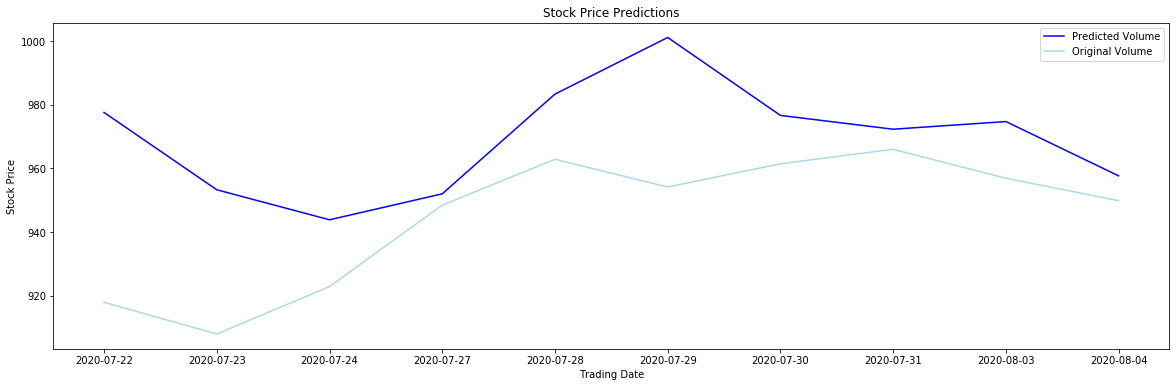

In [24]:
# Visualising the results
import matplotlib.pyplot as plt

plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')

plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')

plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

### Plotting the predictions for full data

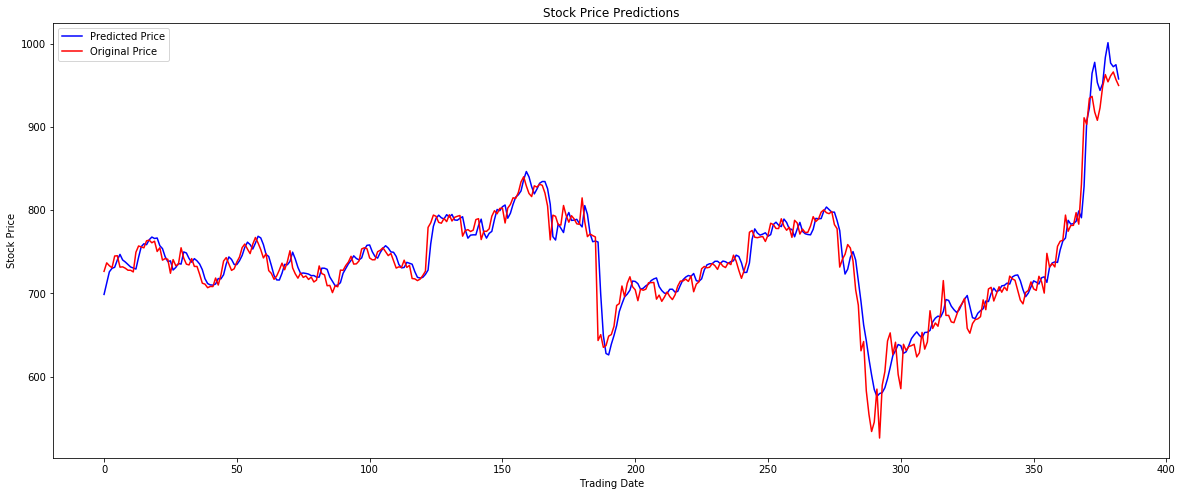

In [25]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))

FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]

# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'red', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

## PREDICTION OF PRICE FOR NEXT DAY

In [26]:
len(X)

393

In [27]:
x_input=X[383:393].reshape(1,-1)
x_input.shape

(1, 10)

In [28]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [29]:
temp_input

[0.8905699010351493,
 0.8679331134114436,
 0.9018314184961893,
 0.9600728017290412,
 0.9928335797975203,
 0.9730406097144808,
 0.9896485041519738,
 1.0,
 0.9792970083039472,
 0.9632578773745877]

In [30]:
# demonstrate prediction for next days
from numpy import array

lst_output=[]
n_steps=10
i=0
while(i<1):
    
    if(len(temp_input)>10):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = regressor.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = regressor.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9349267]
11
[[0.9349266886711121]]


In [31]:
pre = DataScaler.inverse_transform(lst_output)

In [32]:
#Prediction of price for next day
print("predicted Price",pre)

predicted Price [[937.39702601]]


### GRAPH of predicted price vs actual price (30/07/20 to 05/08/20) 

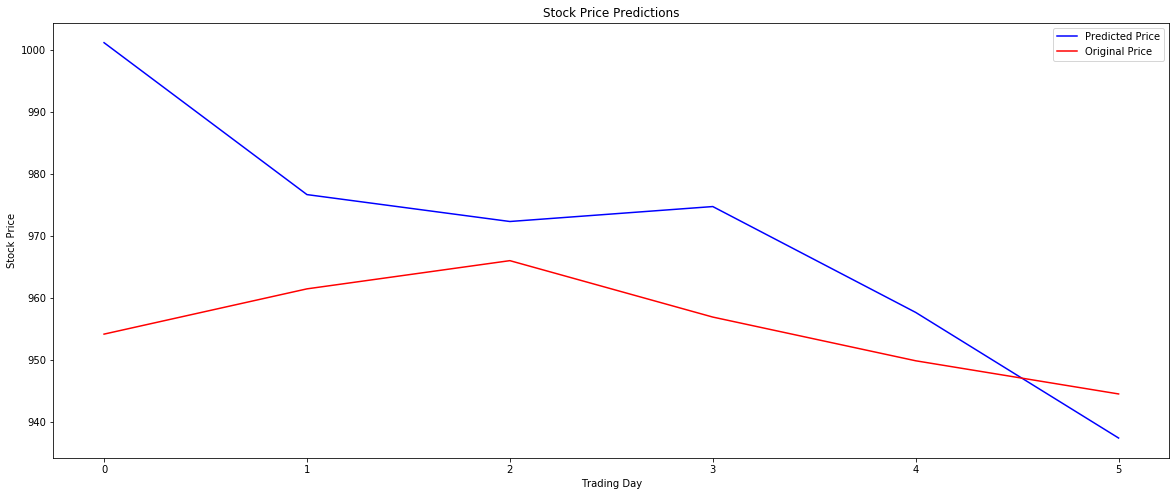

In [35]:
# Generating list of prediction and actual price daywise
predictedprice =[1001.1546,976.6532,972.3142,974.7243,957.6501,937.39]
actualprice =[954.15,961.45,966.0,956.9,949.85,944.50]
# plotting the full data
plt.plot(predictedprice, color = 'blue', label = 'Predicted Price')
plt.plot(actualprice, color = 'red', label = 'Original Price')


plt.title('Stock Price Predictions')
plt.xlabel('Trading Day')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

## Accuracy of prediction (based on 6days data)

In [36]:
# Accuracy of the predictions
X=np.array(predictedprice)
Y=np.array(actualprice)
100 - (100*(abs(Y-X)/Y)).mean()

98.23367674950285